In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from collections import Counter
import re

### Notes:
- There should be standardized approaches for generating centroids of the design and the phenotype images
- Inputs to matching function should be the x,y coordinates of centroids
- ...

# POST PROCESSING OF COLORING

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from collections import Counter
import re

In [3]:
df = pd.read_csv("matchedDF.csv")
df.head(100)

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,2400,600,m,1465,631,m
1,3000,600,m,1819,607,m
2,3600,600,m,2130,612,m
3,4200,600,m,2444,617,m
4,4800,600,m,2774,592,m
...,...,...,...,...,...,...
95,6000,3150,g,3403,1969,g
96,6600,3150,g,3742,1938,g
97,7200,3150,g,4018,1915,g
98,7800,3150,g,4379,1934,g


In [4]:
colOrd = ['m','g','b','y','r']
cnts = list(Counter(df.yInit.values).values())
nCols = len(colOrd)
colors = [colOrd[i % nCols] for i, _ in enumerate(cnts)]



initIdx = []
for c in colOrd:
    cCnts = [cnt for col, cnt in list(zip(colors, cnts)) if col == c]
    dfc = df[df.colorInit == c].sort_values(by=['yInit'])
    start = 0
    idxs = []
    for cnt in cCnts:
        idxs.extend(dfc.iloc[start:start + cnt, :].sort_values(by=["xInit"]).index.values)
        start += cnt

    initIdx.extend(idxs)


phenoIdx = []
for c in colOrd:
    cCnts = [cnt for col, cnt in list(zip(colors, cnts)) if col == c]
    dfc = df[df.colorPheno == c].sort_values(by=['yPheno'])
    start = 0
    idxs = []
    for cnt in cCnts:
        idxs.extend(dfc.iloc[start:start + cnt, :].sort_values(by=["xPheno"]).index.values)
        start += cnt

    phenoIdx.extend(idxs)


In [7]:
dfINIT = df.iloc[initIdx, :3].copy()

In [8]:
dfPHENO = df.iloc[phenoIdx, 3:6].copy()

In [ ]:
# VALIDATION

In [9]:
np.all(dfINIT.colorInit.values == dfPHENO.colorPheno.values)

True

In [10]:
dfINIT.shape, dfPHENO.shape

((350, 3), (350, 3))

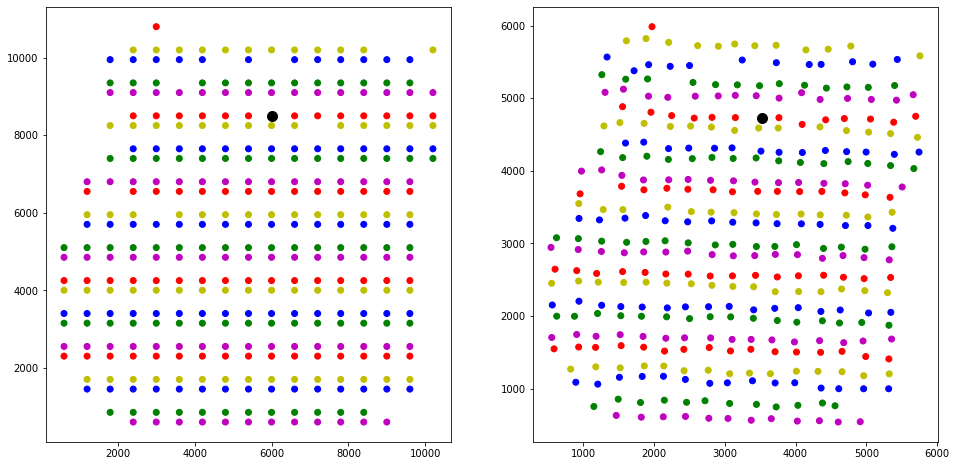

In [11]:
num = np.random.randint(low = 0, high = 350, size=1)

#for num in range(350):

fig, axes = plt.subplots(1,2, figsize=(16,8))
#plt.figure(figsize = (8,8))
axes[0].scatter(dfINIT.xInit.values, dfINIT.yInit.values, c=dfINIT.colorInit.values)
axes[0].scatter(dfINIT.xInit.values[num], dfINIT.yInit.values[num], c='black', s=100)

#plt.figure(figsize = (8,8))
axes[1].scatter(dfPHENO.xPheno.values, dfPHENO.yPheno.values, c=dfPHENO.colorPheno.values)
axes[1].scatter(dfPHENO.xPheno.values[num], dfPHENO.yPheno.values[num], c='black', s=100)

#plt.pause(0.0001)

In [ ]:
# JOINED

In [12]:
s = dfINIT.reset_index(drop=True)
e = dfPHENO.reset_index(drop=True)
dfPaired = s.join(e)

In [13]:
dfPaired

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,2400,600,m,1465,631,m
1,3000,600,m,1819,607,m
2,3600,600,m,2130,612,m
3,4200,600,m,2444,617,m
4,4800,600,m,2774,592,m
...,...,...,...,...,...,...
345,8400,8500,r,4689,4720,r
346,9000,8500,r,5059,4713,r
347,9600,8500,r,5387,4669,r
348,10200,8500,r,5698,4751,r


In [16]:
np.all(dfPaired.colorInit == dfPaired.colorPheno)

True

In [22]:
dfRewards = pd.read_csv("exported_metrics_updated.csv")

In [23]:
dfRewards.head()

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y
0,0.118863,137.0,0.637681,5985,1971
1,1.025394,222.0,0.369176,5790,1609
2,3.039071,300.0,0.409836,5821,1886
3,3.822027,298.0,0.344729,5769,2206
4,4.193993,263.0,0.429032,5747,3140


In [27]:
set(dfRewards.Centroid_x.values) == set(dfPaired.yPheno.values), set(dfRewards.Centroid_y.values) == set(dfPaired.xPheno.values)

(True, True)

In [76]:
newIX = [np.where((posP[i] == posR).all(axis=1))[0][0] for i in range(posP.shape[0])]

In [90]:
dfRSorted = dfRewards.iloc[newIX]#[['Dipole', 'Elongation', 'Aspect_Ratio']]

In [92]:
dfRSorted[['Dipole', 'Elongation', 'Aspect_Ratio']].reset_in

,Dipole,Elongation,Aspect_Ratio
339,4.183770,276.0,0.481707
342,3.083914,260.0,0.372093
344,5.660618,292.0,0.397183
340,4.689636,247.0,0.402730
346,4.927941,277.0,0.390244
...,...,...,...
63,0.058833,55.0,0.724359
62,0.355173,70.0,0.613793
67,0.796311,71.0,0.739130
64,3.274894,204.0,1.010101


In [116]:
dfRSorted.reset_index(drop=True)

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y
0,4.183770,276.0,0.481707,631,1465
1,3.083914,260.0,0.372093,607,1819
2,5.660618,292.0,0.397183,612,2130
3,4.689636,247.0,0.402730,617,2444
4,4.927941,277.0,0.390244,592,2774
...,...,...,...,...,...
345,0.058833,55.0,0.724359,4720,4689
346,0.355173,70.0,0.613793,4713,5059
347,0.796311,71.0,0.739130,4669,5387
348,3.274894,204.0,1.010101,4751,5698


In [120]:
dfMatched = pd.concat([dfPaired,dfRSorted.reset_index(drop=True)], axis=1)#

In [121]:
dfMatched

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y
0,2400,600,m,1465,631,m,4.183770,276.0,0.481707,631,1465
1,3000,600,m,1819,607,m,3.083914,260.0,0.372093,607,1819
2,3600,600,m,2130,612,m,5.660618,292.0,0.397183,612,2130
3,4200,600,m,2444,617,m,4.689636,247.0,0.402730,617,2444
4,4800,600,m,2774,592,m,4.927941,277.0,0.390244,592,2774
...,...,...,...,...,...,...,...,...,...,...,...
345,8400,8500,r,4689,4720,r,0.058833,55.0,0.724359,4720,4689
346,9000,8500,r,5059,4713,r,0.355173,70.0,0.613793,4713,5059
347,9600,8500,r,5387,4669,r,0.796311,71.0,0.739130,4669,5387
348,10200,8500,r,5698,4751,r,3.274894,204.0,1.010101,4751,5698


In [122]:
dfMatched.to_csv('dfMatchedFinal')

In [54]:
df = pd.read_csv('dfPairedRandom7_corrected.csv')

In [55]:
df.head()

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,3900,100,m,3921.502,234.496,m
1,3100,300,g,3262.151,390.541,g
2,4500,300,g,4548.298,431.992,g
3,2500,500,b,2445.344,583.191,b
4,5700,500,b,5797.403,706.733,b


# FINDING NEIGHBORHOODS OF DESIGN MATRIX

In [56]:
coords = np.array(list(zip(df.xInit.values, df.yInit.values)))

In [61]:
searchLen = 1000
xRange = (np.max(coords[:,0]) - np.min(coords[:,0])) #+ 2*searchLenNorm
yRange = (np.max(coords[:,1]) - np.min(coords[:,1])) #+ 2*searchLenNorm
globalLen = max(xRange, yRange)
    
newMat = np.zeros((globalLen, globalLen))
newx, newy = coords[:,0]+searchLen, coords[:,1]+searchLen

In [ ]:
xRange = (np.max(coords[:,0]) - np.min(coords[:,0])) #+ 2*searchLenNorm
yRange = (np.max(coordsNorm[:,1]) - np.min(coordsNorm[:,1])) #+ 2*searchLenNorm
globalLen = max(xRange, yRange)
    
newMat = np.zeros((globalLen, globalLen))
newx, newy = coordsNorm[:,0]+searchLen, coordsNorm[:,1]+searchLen
    
for x,y in list(zip(newx,newy)):
    bLeftx, bLefty = x-1, y-1
    for xShift in range(4):
        for yShift in range(4):
            newMat[bLeftx + xShift, bLefty + yShift] = 1
                
bBoxes = []            
pad = 1 
# search length and boxSideLen in microns
for coordX, coordY in list(zip(newx, newy)):
    #testX = newx[130]
    #testY = newy[130]

    #newMat[testX,testY] = 255

    xbndL, xbndU = coordX - searchLen, coordX + searchLen + pad
    ybndL, ybndU = coordY - searchLen, coordY + searchLen + pad

    bbox = newMat[xbndL:xbndU, ybndL:ybndU]        


    #xBBox = (coordsNorm[:,0] >= xbndL) & (coordsNorm[:,0] <= xbndU)
    #yBBox = (coordsNorm[:,1] >= ybndL) & (coordsNorm[:,1] <= ybndU)
    #neighborIX = np.where(xbool & ybool)

    bBoxes.append(bbox)
    
#neighbors = findNeighbors(coords, 1000) 

In [164]:
def findNeighbors(coords, searchLen):
    # INPUTS ########
        # coords: coordinates of design matrix
        # searchLen: side length of box within which neighbors will be searched for
    # OUTPUTS #######
        # bbox: matrix of neighborhood
        # associated coordinates
    
    searchLenNorm = searchLen//50
    coordsNorm = coords//50
    
    xRange = (np.max(coordsNorm[:,0]) - np.min(coordsNorm[:,0])) + 3*searchLenNorm
    yRange = (np.max(coordsNorm[:,1]) - np.min(coordsNorm[:,1])) + 3*searchLenNorm
    globalLen = max(xRange, yRange)
    
    newMat = np.zeros((globalLen, globalLen))
    newx, newy = coordsNorm[:,0]+searchLenNorm, coordsNorm[:,1]+searchLenNorm
    
    for x,y in list(zip(newx,newy)):
        bLeftx, bLefty = x-1, y-1
        for xShift in range(4):
            for yShift in range(4):
                newMat[bLeftx + xShift, bLefty + yShift] = 1
                
    bBoxes = []            
    pad = 1 
    # search length and boxSideLen in microns
    for coordX, coordY in list(zip(newx, newy)):
        #testX = newx[130]
        #testY = newy[130]

        #newMat[testX,testY] = 255

        xbndL, xbndU = coordX - searchLenNorm, coordX + searchLenNorm + pad
        ybndL, ybndU = coordY - searchLenNorm, coordY + searchLenNorm + pad

        bbox = newMat[xbndL:xbndU, ybndL:ybndU]        
        

        #xBBox = (coordsNorm[:,0] >= xbndL) & (coordsNorm[:,0] <= xbndU)
        #yBBox = (coordsNorm[:,1] >= ybndL) & (coordsNorm[:,1] <= ybndU)
        #neighborIX = np.where(xbool & ybool)

        bBoxes.append(bbox)
    
    return bBoxes
    
neighbors = findNeighbors(coords, 1000) 

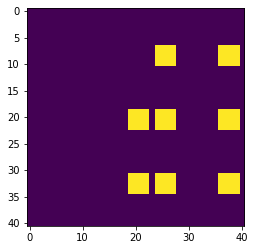

In [256]:
plt.imshow(neighbors[0])

In [231]:
len(neighbors)

350

In [295]:
flatLocals = pd.DataFrame([neighbor.flatten().astype(int) for neighbor in neighbors])

In [297]:
dfMatched = pd.concat([dfMatched, flatLocals], axis = 1)

In [234]:
np.save("pairedLocalities", np.array(neighbors))

In [344]:
dfMatched.to_csv("dfPairedFull.csv", index=False)

# Random 7

In [22]:
dfFinal = pd.read_csv("random_7_final_crop_roi_centroids.csv")
dfInit = pd.read_csv("random_7_init_crop_roi_centroids.csv")

In [23]:
dfFinal.head()

,,Area,Mean,X,Y,BX,BY,Width,Height
0,1,92222.217,12495.986,3921.502,234.496,3742.054,50.70,358.80,349.05
1,2,85822.597,12295.957,3262.151,390.541,3084.903,193.05,339.30,386.10
2,3,64422.084,11190.062,4548.298,431.992,4407.004,282.75,278.85,310.05
3,4,80997.214,12566.847,2445.344,583.191,2267.852,388.05,384.15,370.50
4,5,59737.394,10536.496,6465.985,577.260,6323.856,444.60,308.10,273.00


In [24]:
dfInit.head()

,,Area,Mean,X,Y,BX,BY,Width,Height,Unnamed: 9
0,1,17312.817,1088.198,3883.113,60.642,3810.304,0.00,146.25,128.70,NaN
1,2,16776.664,998.327,3104.850,244.868,3036.153,173.55,138.45,140.40,NaN
2,3,18464.977,1020.912,4491.049,253.859,4412.854,177.45,150.15,152.10,NaN
3,4,14810.767,910.686,6253.114,457.731,6189.306,390.00,130.65,130.65,NaN
4,5,16229.102,965.339,5680.207,461.942,5610.156,393.90,140.40,134.55,NaN


In [34]:
np.save('finalRandom7.npy', np.array([dfFinal.X.values, dfFinal.Y.values]).T )

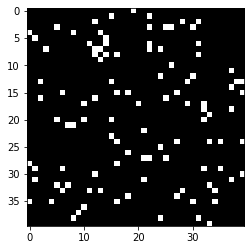

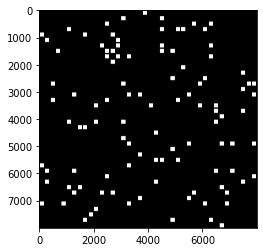

In [74]:
# RANDOM ARRAY
# each pixel is 200 x 200 micron (150 x 150 micron square with 25 µm padding)
# overall patterning area is 8000 x 8000 micron (40 x 40 pixels)
# 1/16 of pixels (100/1600 pixels) are filled on average (9% for n=144)

np.random.seed(7) # set random seed for reproducibility
f = 1/16 
a = np.random.rand(40,40) 
b = np.where(a < f, 1, 0) # binary image
plt.figure()
plt.imshow(b, plt.cm.gray)

# generate full array, where each pixel is now 1 x 1 micron
cx = []
cy = []
res_lo = np.argwhere(b == 1)
res = res_lo*200+25
im = np.zeros((8000, 8000))
for k in range(res.shape[0]):
    y, x = res[k][0], res[k][1]
    im[y:y+150,x:x+150] = 1
    cx.append(x+75)
    cy.append(y+75)
plt.figure()
plt.imshow(im, plt.cm.gray)
plt.show()

In [64]:
np.save('initRandom7.npy', np.array([np.array(cx), np.array(cy)]).T)


In [65]:
hi = np.load('initRandom7.npy')

In [120]:
(coords//50)[69]

array([ 74, 106])

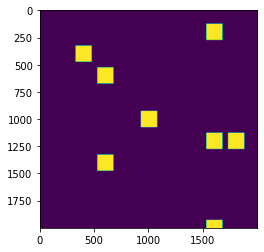

In [108]:
num = 69
r = 1000
x = coords[num][1]
y = coords[num][0]
ux = x+r
uy = y+r
lx = x-r
ly = y-r
plt.imshow(im[lx:ux, ly:uy])

hi = im[lx:ux, ly:uy]

In [115]:
hiScaled = cv2.resize(hi, dsize=(40, 40)) #, interpolation=cv2.INTER_CUBIC

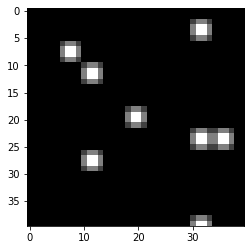

In [117]:
plt.imshow(hiScaled, plt.cm.gray)

# FIXING

In [2]:
df = pd.read_csv("dfPaired_random7.csv")

In [3]:
df

,Unnamed: 0,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,0,3900,100,m,3065.503,1212.471,m
1,1,2900,1100,m,296.187,1271.595,m
2,2,300,1100,m,5374.386,2246.644,m
3,3,5300,2100,m,3921.502,234.496,m
4,4,1300,3100,m,1390.256,3340.405,m
...,...,...,...,...,...,...,...
100,100,6500,5900,r,6615.153,6082.096,r
101,101,6700,7900,r,7249.204,6082.881,r
102,102,1700,900,r,5608.104,7169.708,r
103,103,2700,900,r,6948.166,8077.107,r


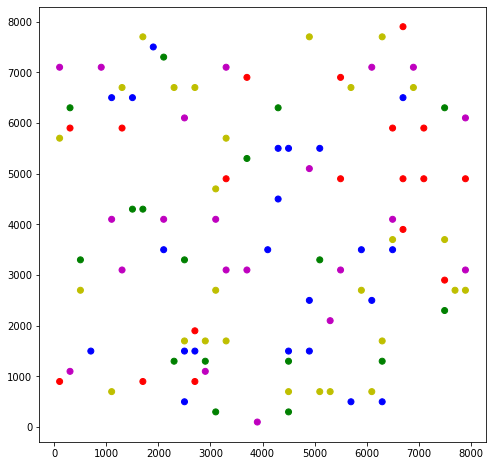

In [4]:
plt.figure(figsize = (8,8))
plt.scatter(df.xInit, df.yInit, c = df.colorInit)

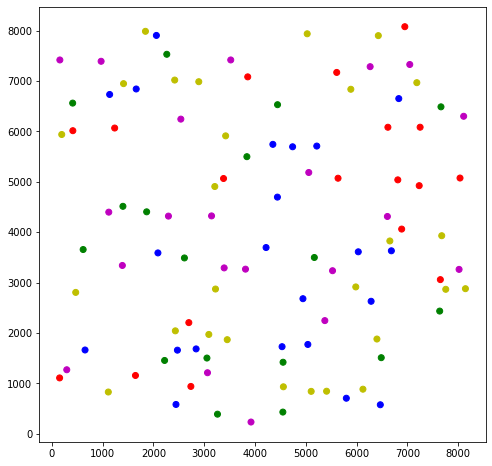

In [5]:
plt.figure(figsize = (8,8))
plt.scatter(df.xPheno, df.yPheno, c = df.colorPheno)

In [6]:
# make color vector from matched color plots
cnts = list(Counter(df.sort_values(by='yInit').yInit.values).values())
colors = ['m','g','b','y','r']
nCols = len(colors)
colorsOrder = [colors[i % nCols] for i, _ in enumerate(cnts)]

In [7]:
dfSorted_InitY = df.sort_values(by='yInit')
initIx = []
start = 0
for cnt in cnts:
    subDf = dfSorted_InitY.iloc[start:start+cnt,:]
    initInds = subDf.sort_values(by='xInit').index.values
    initIx.extend(initInds)
    start += cnt

In [8]:
dfSorted_PhenoY = df.sort_values(by='yPheno').reset_index()


In [9]:
dfSorted_PhenoY

,index,Unnamed: 0,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,3,3,5300,2100,m,3921.502,234.496,m
1,28,28,2500,3300,g,3262.151,390.541,g
2,29,29,500,3300,g,4548.298,431.992,g
3,54,54,4500,5500,b,6465.985,577.260,b
4,53,53,4300,5500,b,2445.344,583.191,b
...,...,...,...,...,...,...,...,...
100,83,83,6100,700,y,6426.703,7899.796,y
101,59,59,1900,7500,b,2059.925,7903.598,b
102,81,81,5100,700,y,5027.466,7936.405,y
103,80,80,4500,700,y,1844.642,7985.327,y


In [32]:
dfSorted_PhenoY["temp"] = [0]*dfSorted_PhenoY.shape[0]

In [33]:
dfSorted_PhenoY.head(100)

,index,Unnamed: 0,xInit,yInit,colorInit,xPheno,yPheno,colorPheno,temp
0,3,3,5300,2100,m,3921.502,234.496,m,0
1,28,28,2500,3300,g,3262.151,390.541,g,0
2,29,29,500,3300,g,4548.298,431.992,g,0
3,54,54,4500,5500,b,6465.985,577.260,b,0
4,53,53,4300,5500,b,2445.344,583.191,b,0
...,...,...,...,...,...,...,...,...,...
95,19,19,6900,7100,m,7045.534,7327.044,m,0
96,20,20,900,7100,m,972.090,7390.824,m,0
97,16,16,100,7100,m,160.304,7417.108,m,0
98,17,17,3300,7100,m,3522.822,7417.154,m,0


In [12]:
n = dfSorted_PhenoY.shape[0]
phenoIx = []
#start = 0
for i, cnt in enumerate(cnts):
    c = colorsOrder[i]
    subDf = dfSorted_PhenoY[(dfSorted_PhenoY.colorPheno == c) & (dfSorted_PhenoY.temp == 0)].iloc[:cnt,:]
    
    # add indices to list
    phenoInds = subDf.sort_values(by='xPheno')["index"].values
    phenoIx.extend(phenoInds)
    
    # mark the indices which have been recorded and update
    temp = dfSorted_PhenoY.temp.values
    for ix in subDf.index.values:
        temp[ix] = 1    
    dfSorted_PhenoY["temp"] = temp 

In [13]:
dfINIT = df.loc[initIx].iloc[:, 1:4].copy()

In [14]:
dfPHENO = df.loc[phenoIx].iloc[:, 4:7].copy()

In [15]:
dfPHENO

,xPheno,yPheno,colorPheno
3,3921.502,234.496,m
28,3262.151,390.541,g
29,4548.298,431.992,g
53,2445.344,583.191,b
58,5797.403,706.733,b
...,...,...,...
59,2059.925,7903.598,b
80,1844.642,7985.327,y
81,5027.466,7936.405,y
83,6426.703,7899.796,y


In [16]:
dfINIT

,xInit,yInit,colorInit
0,3900,100,m
23,3100,300,g
27,4500,300,g
48,2500,500,b
52,5700,500,b
...,...,...,...
59,1900,7500,b
84,1700,7700,y
85,4900,7700,y
86,6300,7700,y


In [17]:
np.all(dfINIT.colorInit.values == dfPHENO.colorPheno.values)

True

In [18]:
dfINIT_resetIx = dfINIT.reset_index()

In [19]:
dfPHENO_resetIx = dfPHENO.reset_index()

In [20]:
np.all(dfINIT_resetIx.colorInit == dfPHENO_resetIx.colorPheno)

True

In [21]:
dfPHENO_resetIx

,index,xPheno,yPheno,colorPheno
0,3,3921.502,234.496,m
1,28,3262.151,390.541,g
2,29,4548.298,431.992,g
3,53,2445.344,583.191,b
4,58,5797.403,706.733,b
...,...,...,...,...
100,59,2059.925,7903.598,b
101,80,1844.642,7985.327,y
102,81,5027.466,7936.405,y
103,83,6426.703,7899.796,y


In [22]:
dfINIT_resetIx.loc[100]

index          59
xInit        1900
yInit        7500
colorInit       b
Name: 100, dtype: object

In [23]:
dfPHENO_resetIx.loc[100]

index               59
xPheno        2059.925
yPheno        7903.598
colorPheno           b
Name: 100, dtype: object

In [27]:
hi = dfINIT_resetIx.iloc[:, 1:].join(dfPHENO_resetIx.iloc[:,1:])

In [29]:
np.all(hi.colorInit.values == hi.colorPheno.values)

True

In [35]:
hi.to_csv('dfPairedRandom7_corrected', index = False)

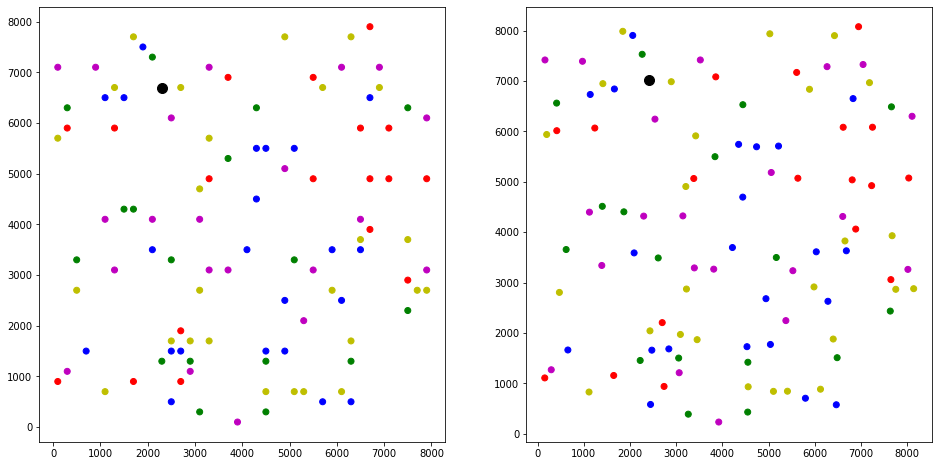

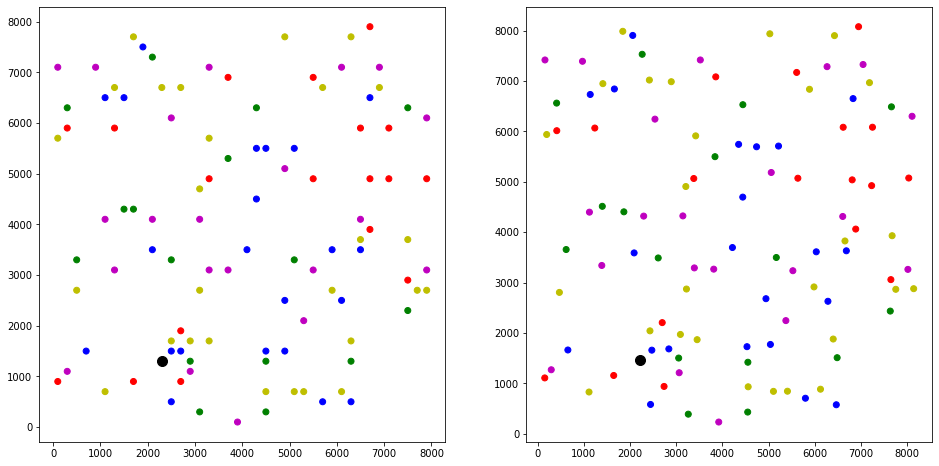

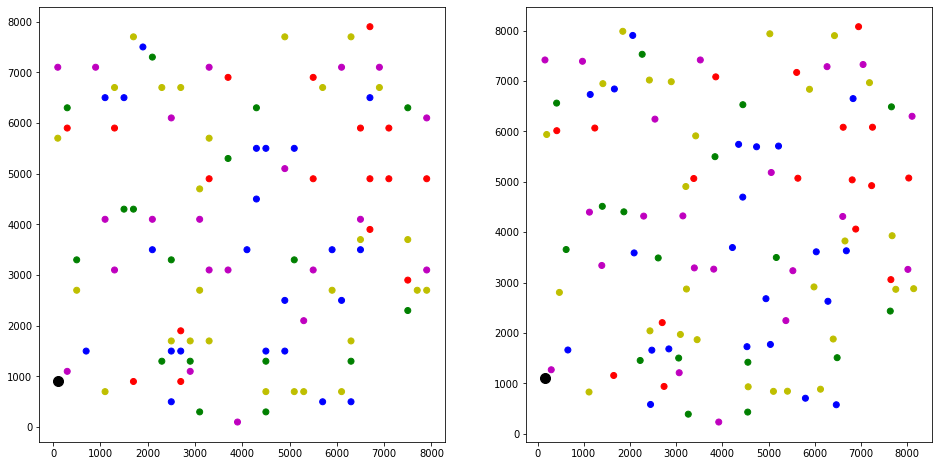

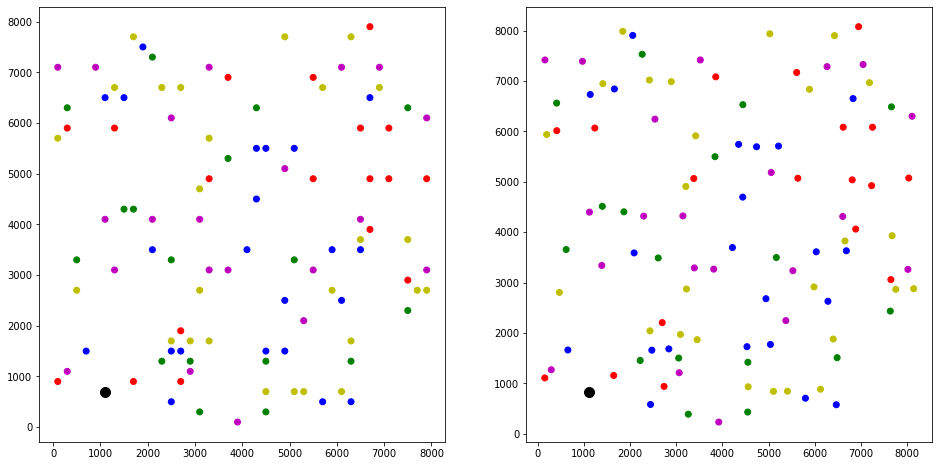

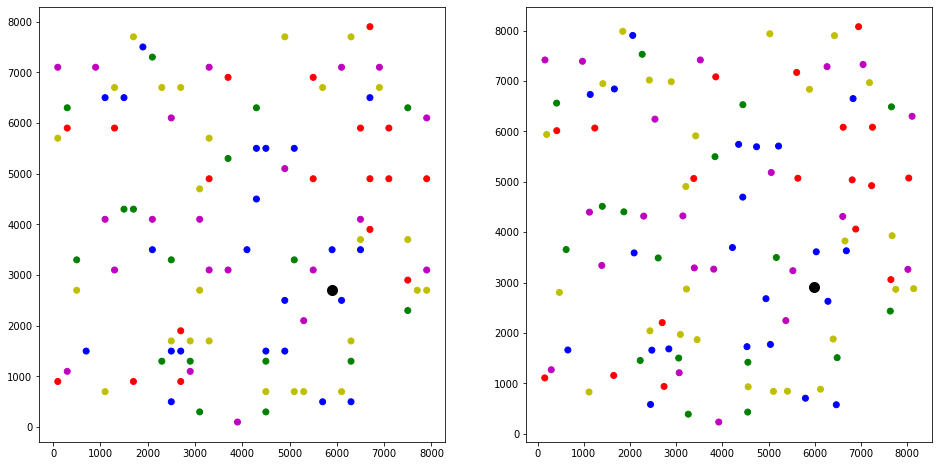

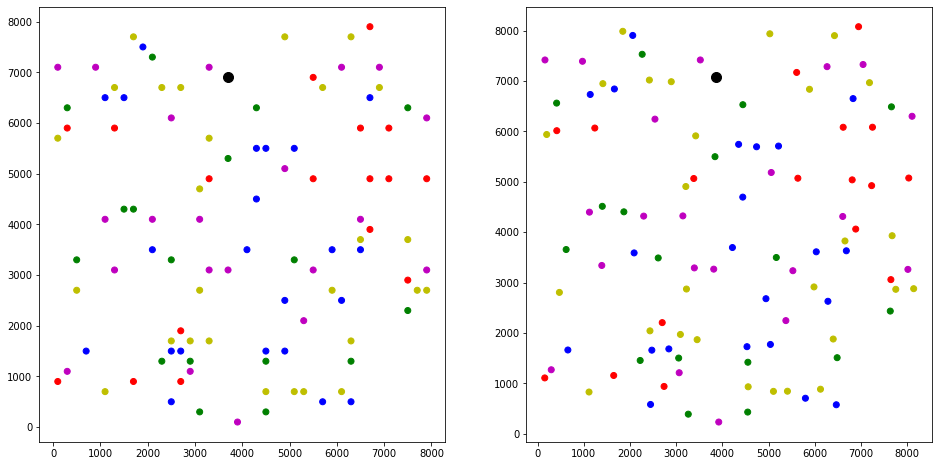

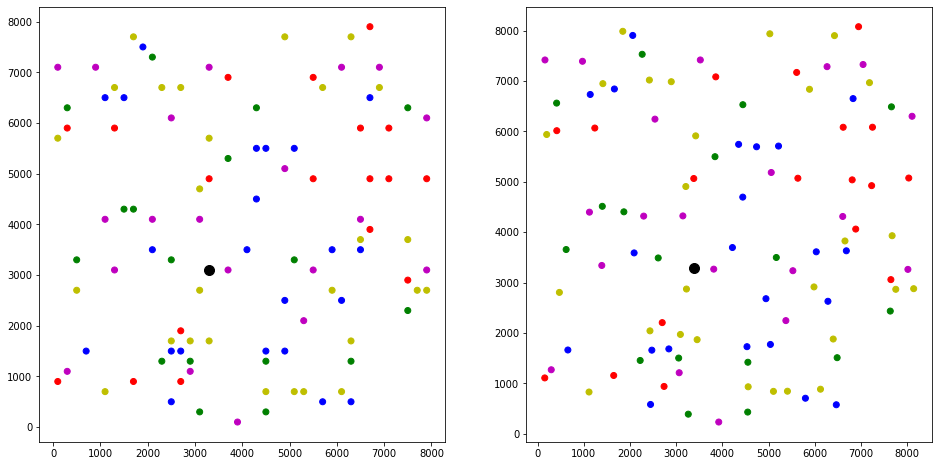

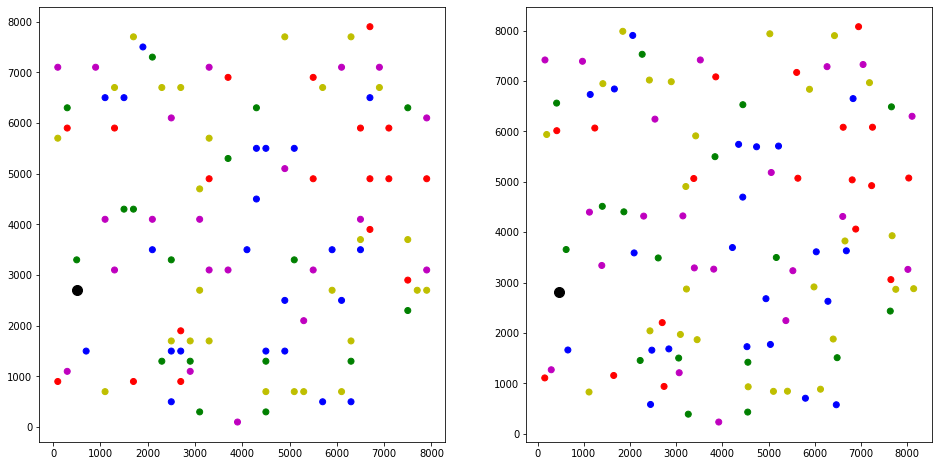

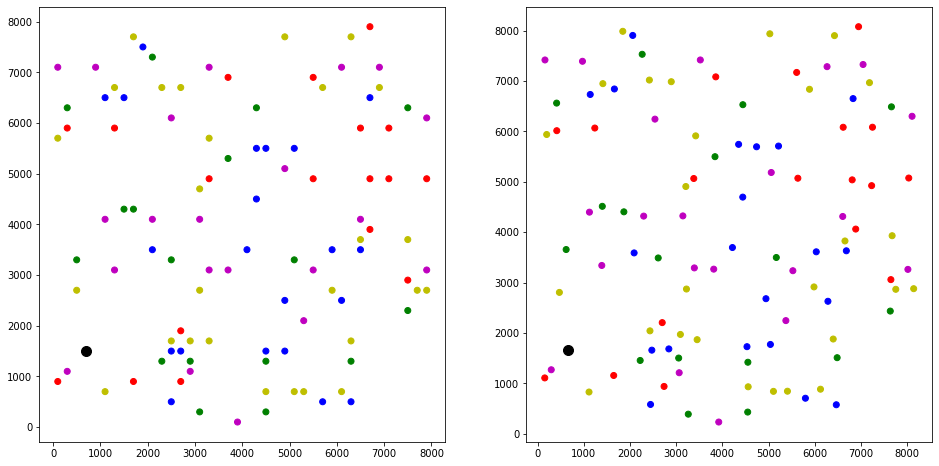

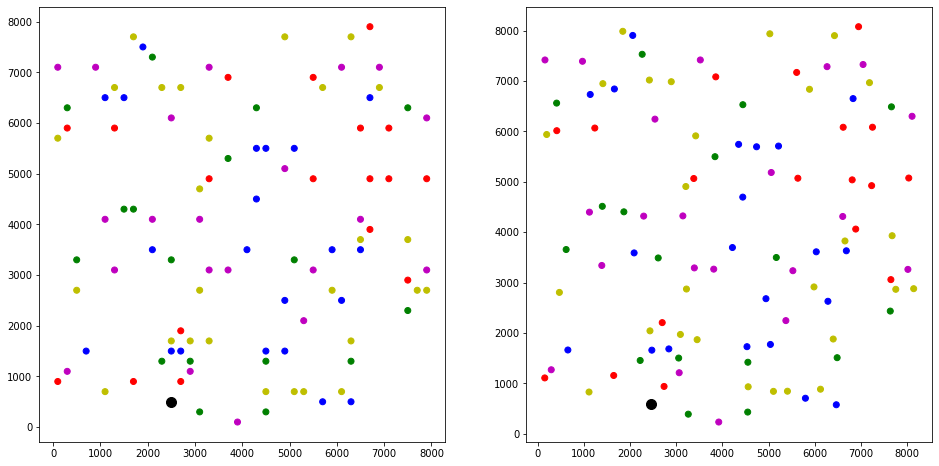

In [36]:
for _ in range(10):
    num = np.random.randint(low = 0, high = dfINIT.shape[0], size=1)
    #for num in range(350):

    fig, axes = plt.subplots(1,2, figsize=(16,8))
    #plt.figure(figsize = (8,8))
    axes[0].scatter(dfINIT.xInit.values, dfINIT.yInit.values, c=dfINIT.colorInit.values)
    axes[0].scatter(dfINIT_resetIx.loc[num].xInit, dfINIT_resetIx.loc[num].yInit, c='black', s=100)

    #plt.figure(figsize = (8,8))
    axes[1].scatter(dfPHENO.xPheno.values, dfPHENO.yPheno.values, c=dfPHENO.colorPheno.values)
    axes[1].scatter(dfPHENO_resetIx.xPheno[num], dfPHENO_resetIx.yPheno[num], c='black', s=100)

#plt.pause(0.0001)

In [317]:
num

array([100])

In [133]:
df.head()

,Unnamed: 0,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,0,3900,100,m,3065.503,1212.471,m
1,1,2900,1100,m,296.187,1271.595,m
2,2,300,1100,m,5374.386,2246.644,m
3,3,5300,2100,m,3921.502,234.496,m
4,4,1300,3100,m,1390.256,3340.405,m


In [137]:
list(Counter(df.yInit.values).values())

[1,
 2,
 1,
 5,
 4,
 1,
 2,
 5,
 4,
 2,
 1,
 3,
 2,
 1,
 3,
 1,
 5,
 4,
 2,
 3,
 1,
 3,
 3,
 1,
 4,
 5,
 2,
 1,
 2,
 5,
 5,
 3,
 1,
 1,
 1,
 5,
 4,
 2,
 1,
 3]

In [135]:
cCnts

[4, 2, 3, 3, 4, 5, 1, 3]

In [134]:
df.sort_values("yInit", ascending=False)

,Unnamed: 0,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
101,101,6700,7900,r,7249.204,6082.881,r
85,85,4900,7700,y,5408.764,845.981,y
86,86,6300,7700,y,6124.086,885.858,y
84,84,1700,7700,y,4558.598,933.558,y
59,59,1900,7500,b,2059.925,7903.598,b
...,...,...,...,...,...,...,...
51,51,6300,500,b,5215.626,5708.961,b
48,48,2500,500,b,4218.093,3696.104,b
27,27,4500,300,g,5167.676,3498.529,g
23,23,3100,300,g,2611.355,3489.471,g


In [ ]:
sorted_df = df.sort_values("Age", ascending=False)
Sort by `"Age"` column

grouped_df = sorted_df.groupby("Name")
Group rows by `"Name"` column

print(grouped_df.get_group("Alex"))